# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from past.builtins import xrange
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


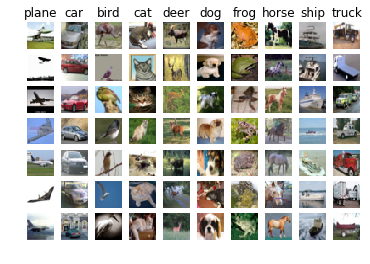

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # 5000 x 32 x 32 x 3 --> 5000 x 3072
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
X_train[0]

array([ 59.,  62.,  63., ..., 123.,  92.,  72.])

In [7]:
X_test[0].shape

(3072,)

In [8]:
a = np.array(np.random.rand(4,6))
a = np.reshape(a, (1,4,6))
b = np.array(np.random.rand(4,6))
b = np.reshape(b, (1,4,6))
# a[0,:]
np.sqrt(np.sum((b[0,:] - a[0,:])**2,axis = 1))
# np.sqrt(np.sum(b[0,:] - a[0,:], axis = 0)**2)

array([0.70302602, 1.1393776 , 0.95400177, 0.59617258])

In [9]:
a = np.array(np.random.rand(4,6))
c = np.array(np.random.rand(4,6))
print(a)
print(c[1,:])
c[1,:] - a

[[0.16429258 0.07505628 0.4333781  0.23184672 0.13945649 0.68527265]
 [0.09214693 0.29682954 0.95581442 0.32815403 0.47615948 0.72376059]
 [0.43093837 0.59548715 0.92919715 0.9695264  0.4967995  0.03247201]
 [0.59910705 0.64230441 0.11617835 0.22812034 0.08037168 0.23509641]]
[0.96201389 0.03081954 0.89473392 0.65682852 0.52552808 0.1033684 ]


array([[ 0.79772131, -0.04423674,  0.46135582,  0.4249818 ,  0.38607159,
        -0.58190425],
       [ 0.86986696, -0.26601   , -0.0610805 ,  0.32867448,  0.04936859,
        -0.62039218],
       [ 0.53107552, -0.56466761, -0.03446323, -0.31269788,  0.02872857,
         0.07089639],
       [ 0.36290684, -0.61148487,  0.77855556,  0.42870818,  0.44515639,
        -0.131728  ]])

In [10]:
print(a)
print(a**2)
np.sqrt(np.sum(a**2,axis = 1))

[[0.16429258 0.07505628 0.4333781  0.23184672 0.13945649 0.68527265]
 [0.09214693 0.29682954 0.95581442 0.32815403 0.47615948 0.72376059]
 [0.43093837 0.59548715 0.92919715 0.9695264  0.4967995  0.03247201]
 [0.59910705 0.64230441 0.11617835 0.22812034 0.08037168 0.23509641]]
[[0.02699205 0.00563345 0.18781657 0.0537529  0.01944811 0.46959861]
 [0.00849106 0.08810778 0.91358121 0.10768507 0.22672785 0.52382939]
 [0.18570788 0.35460494 0.86340734 0.93998143 0.24680975 0.00105443]
 [0.35892926 0.41255496 0.01349741 0.05203889 0.00645961 0.05527032]]


array([0.87363705, 1.36690247, 1.60983408, 0.9480245 ])

In [11]:
a = np.array(np.random.rand(20,6))
b = np.array(np.random.rand(2,6))
c = np.dot(a,b.T)
print(c.shape)
c

(20, 2)


array([[1.91559503, 1.64681813],
       [1.71420828, 1.11862183],
       [1.80127879, 1.35542878],
       [1.66666251, 1.30507861],
       [1.42408447, 0.94997131],
       [1.26443769, 0.7533214 ],
       [1.85599963, 1.62108994],
       [1.32549432, 0.8796754 ],
       [1.58412245, 1.10432947],
       [2.37561164, 2.22072908],
       [1.7119316 , 1.56098377],
       [1.7622968 , 1.32246942],
       [1.60742909, 1.1924976 ],
       [1.65702277, 0.999567  ],
       [1.72449153, 1.08731398],
       [2.27961598, 1.7901004 ],
       [2.00619113, 1.49213512],
       [1.44628002, 0.91711042],
       [1.57822363, 1.17784412],
       [2.35040384, 2.12444774]])

In [12]:
-2 * c + (np.sum(a**2,axis = 1)).reshape(20,1) + (np.sum(b**2, axis = 1).reshape(1,2))

array([[1.52207682, 1.58208467],
       [0.27608859, 0.98971555],
       [0.33655832, 0.7507124 ],
       [0.34057153, 0.58619339],
       [0.51385035, 0.98453073],
       [0.75088802, 1.29557465],
       [0.41803763, 0.41031107],
       [1.17532321, 1.58941511],
       [0.69384131, 1.17588132],
       [0.48353368, 0.31575286],
       [0.63463261, 0.45898232],
       [0.93707379, 1.33918262],
       [1.21551539, 1.56783243],
       [0.35042948, 1.18779508],
       [0.80997763, 1.60678678],
       [0.28701599, 0.78850123],
       [0.26957727, 0.82014334],
       [0.51175899, 1.09255226],
       [1.07853428, 1.40174736],
       [0.34088614, 0.31525239]])

In [13]:
dists = np.zeros((10, 15))
dists[0,0]

0.0

In [14]:
y_train[0]

6

In [15]:
# a = np.array([1,2,3,1,2,1,1,1,3,2,2,1]) #np.bincount(np.array([0, 1, 1, 3, 2, 1, 7]))
a = np.array([4])
counts = np.bincount(a)
print(counts)
print(np.argmax(counts))

[0 0 0 0 1]
4


In [16]:
# for i in range(1):
#     print(i)
    
a = np.zeros(3)    
a[0]

0.0

In [17]:
class KNearestNeighbor(object):
    """
    a kNN classifier with L2 distance
    """
    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just 
        memorizing the training data.
        
        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.
        
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        
        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the 
        test data.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            for j in xrange(num_train):
                dists[i,j] = np.sqrt(np.sum((X[i] - self.X_train[j])**2))
#                 print(i,j)
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in xrange(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            #######################################################################
            tmp = (X[i,:] - self.X_train)
            dists[i,:] =np.sqrt(np.sum(tmp**2,axis = 1))
            #######################################################################
            #                         END OF YOUR CODE                            #
            #######################################################################
        return dists
    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train)) 
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy.                #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        dists = np.sqrt((-2) * np.dot(X,self.X_train.T) + (np.sum(self.X_train**2,axis = 1)).\
                        reshape(1,num_train) + (np.sum(X**2, axis = 1).reshape(num_test,1)))
#         c + (np.sum(a**2,axis = 1)).reshape(20,1) + (np.sum(b**2, axis = 1).reshape(1,2))
        #########################################################################
        #                         END OF YOUR CODE                              #
        #########################################################################
        return dists
    
    
    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
#         print(num_test) #500
        for i in xrange(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
#             print(i) #0
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            tmp = np.argsort(dists[i,:])
            for num in range(k):
                closest_y.append(self.y_train[tmp[num]]) # all labels in int
#             print(closest_y) #[4]
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            counts = np.bincount(closest_y)
#             print(counts)
            # np.argmax will return the loc of the max occur int
            # i.e. for np.array([4]) --> counts = [0 0 0 0 1] --> np.argmax(counts) == 4
            y_pred[i] = np.argmax(counts) 
            #########################################################################
            #                           END OF YOUR CODE                            # 
            #########################################################################
            
        return y_pred

In [18]:
# from cs231n.classifiers import KNearestNeighbor # this is getting out of control...

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [19]:
# classifier.train(1,2)

In [20]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


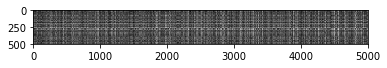

In [21]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?  


- What causes the columns?  


**Your Answer**:  
1. As in the defination, brightness = high distance between two images. i.e. dist[i,j] is bright when image i and image j are very far aprat from each other. As a recent, a bright row indicates that this perticular image i from testing is very different from most of other images in the training dataset.  

2. Similar to the above, bright column means that particular column, which is image j from training dataset is different from most of the images from testing dataset.



In [22]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [23]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [24]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [25]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [26]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 27.588924 seconds
One loop version took 34.912863 seconds
No loop version took 0.195659 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [27]:
x = np.arange(X_train.shape[0])
fold_index = np.array_split(x, 5)

In [28]:
print(fold_index[0][0],fold_index[0][-1])

0 999


In [30]:
# print(len(X_train_folds))
# print(X_train_folds[0].shape)
# print(X_train_folds[1].shape)
# print(X_train_folds[2].shape)
# print(X_train_folds[3].shape)
# print(X_train_folds[4].shape)
# print(X_train_folds[1])
# print(y_train_folds[1])

In [31]:
# np.concatenate(X_train_folds).remove(X_train_folds[0])
# print(type(X_train_folds[0]))

In [32]:
# tmp = np.ndarray(0)
# tmp = np.concatenate(tmp, X_train_folds[0])
t = list(range(5))
t.remove(2)
t

[0, 1, 3, 4]

In [33]:
# local_train_folds = X_train_folds.copy()
# del local_train_folds[0]
# tmp = np.concatenate(local_train_folds)
# print(tmp.shape)
# tmp = np.delete(tmp, X_train_folds[0])
# print(tmp.shape)

In [34]:
np.mean([1,2,3])

2.0

In [35]:
# X_train[]

In [36]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
x = np.arange(X_train.shape[0])
fold_indexs = np.array_split(x, num_folds)
for i in range(num_folds):
    X_train_folds.append(X_train[fold_index[i][0]:(fold_index[i][-1]+1)])
    y_train_folds.append(y_train[fold_index[i][0]:(fold_index[i][-1]+1)])
    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    all_fold_acc = []
    for n in range(num_folds):
        # create local X_train and y_train
        local_train_folds = X_train_folds.copy()
        del local_train_folds[i]
        local_X_train = np.concatenate(local_train_folds)
        
        local_y_folds = y_train_folds.copy()
        del local_y_folds[i]
        local_y_train = np.concatenate(local_y_folds)
        
        local_X_test = X_train_folds[i].copy()
        local_y_test = y_train_folds[i].copy()
        
        # init knn
        classifier = KNearestNeighbor()
        classifier.train(local_X_train, local_y_train)
        
        # compute dist
        local_dist = classifier.compute_distances_no_loops(local_X_test)
        y_test_pred = classifier.predict_labels(local_dist, k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_test_pred == local_y_test)
        accuracy = float(num_correct) / local_y_test.shape[0]
        all_fold_acc.append(accuracy)
    k_to_accuracies[k] = all_fold_acc
#     k_to_accuracies[k] = np.mean(all_fold_acc)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.266000
k = 1, accuracy = 0.266000
k = 1, accuracy = 0.266000
k = 1, accuracy = 0.266000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.280000
k = 10, accuracy = 0.280000
k = 10, accuracy = 0.280000
k = 10, accuracy = 0.280000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.280000
k = 12, accuracy = 0.280000
k = 12, accuracy = 0.280000
k = 12, accuracy = 0.280000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.274000
k = 15, accuracy = 0.274000
k = 15, accuracy = 0.274000
k = 15, accuracy = 0.274000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.285000
k = 20, accu

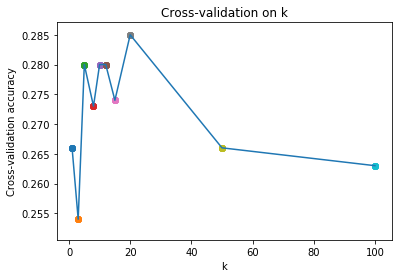

In [37]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [38]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 6

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
